In [1]:
!pip install tensorflow==2.12.0 transformers==4.28.1
!pip install transformers -U
!pip install termcolor
!pip install scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Obtaining dependency information for tensorflow==2.12.0 from https://files.pythonhosted.org/packages/6b/6d/00ef55900312ba8c8aa9d64b13c74fb8cba0afa24cc4a2ce74796f530244/tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for transformers==4.28.1 from https://files.pythonhosted.org/packages/d8/a7/a6ff727fd5d96d6625f4658944a2ae230f0c75743a9a117fbda013b03d3d/transformers-4.28.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 1.4 MB/s eta 0:00:000 MB/s eta 0:00:01
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2

In [1]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

2024-07-29 01:54:54.937870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 01:54:55.132366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 01:54:55.133451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 01:54:58.673040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_file_path = "emitrain.csv"
test_file_path = "emitest.csv"
df = pd.read_csv("emitrain.csv")
df_test = pd.read_csv("emitest.csv")

df['Date'] = pd.to_datetime(df['Date'])

df.head()

/tmp/ipykernel_775/846047351.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Sentiment,Lead ID,Activity ID,Country,Date,Subject,Comments
0,Negative,00QNv000007cGhI,00TNv00000B6ldq,Mexico,2024-05-23,Asako Echizenya sent RE: [EXTERNAL] Reclutamie...,"?? PROTECTED ????? Hola muchas gracias , si ha..."
1,Negative,00QNv00000AIAkj,00TNv00000DEi9x,Mexico,2024-07-19,Jazmín González sent RE: RV: [EXTERNAL] Emi La...,"Hola Carla No, no es lo que buscamos saludos A..."
2,Negative,00QNv000005F4GX,00TNv0000095LGN,Mexico,2024-03-19,Jessica Campos sent RE: [External] Reclutamien...,Gracias Carla. Por el momento no tengo un uso ...
3,Negative,00Q3m00001AkVjW,00T3m00005hUUgA,Mexico,2023-08-09,Laura López sent RE: Continúa descubriendo las...,"Gracias, por el momento no me interesa Laura A..."
4,Neutral,00QNv000003z8Gg,00TNv000009FqKW,Mexico,2024-03-25,[Outreach] [Email] [In] Accepted: [EXTERNAL] U...,"From: Alejandro Apolinar Lopez To: ""Lucas Sandi"""


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Sentiment    912 non-null    object        
 1   Lead ID      912 non-null    object        
 2   Activity ID  912 non-null    object        
 3   Country      770 non-null    object        
 4   Date         912 non-null    datetime64[ns]
 5   Subject      912 non-null    object        
 6   Comments     912 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 50.0+ KB


In [4]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (912, 7)
 DF TEST SHAPE: (193, 7)


In [5]:
df['Sentiment'].value_counts()

Sentiment
Neutral     504
Negative    230
Positive    178
Name: count, dtype: int64

Sample cleaned texts from training data:
0    asakoechienasentreexternalreclutamientomasivoa...
1    jamngonlesentrervexternalemilabspedidodedemopa...
2    jessicacampossentreexternalreclutamientomasivo...
3    lauralpesentrecontinadescubriendolasventajasde...
4    outreachemailinacceptedexternalupdatedinvitati...
Name: text_clean, dtype: object
Sample cleaned texts from testing data:
0    fernandaagredariossentretustiendasconnminasiem...
1    marialucolombarollisentreexternalrespondeatodo...
2    sentreexternalrespondeatodostusaplicantescuida...
3    emailreexternalrespondeatodostusaplicantescuid...
4    marialucolombarollisentreexternalrerespondeato...
Name: text_clean, dtype: object
Tokenizing the following texts:
0    asakoechienasentreexternalreclutamientomasivoa...
1    jamngonlesentrervexternalemilabspedidodedemopa...
2    jessicacampossentreexternalreclutamientomasivo...
3    lauralpesentrecontinadescubriendolasventajasde...
4    outreachemailinacceptedexternalupdatedinvitati..

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'tf_bert_for_sequence_classification/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>
  <tf.Variable 'tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=floa

2024-07-29 01:55:57.538233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [912]
	 [[{{node Placeholder/_2}}]]
2024-07-29 01:55:57.538571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [912]
	 [[{{node Placeholder/_2}}]]
2024-07-29 02:20:18.849870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [193]
	 [[

57/57 - 1756s - loss: 1.1496 - accuracy: 0.2193 - val_loss: 1.1260 - val_accuracy: 0.2798 - 1756s/epoch - 31s/step
Epoch 2/2
57/57 - 1895s - loss: 1.1506 - accuracy: 0.2039 - val_loss: 1.1260 - val_accuracy: 0.2798 - 1895s/epoch - 33s/step


2024-07-29 02:56:48.641632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [193]
	 [[{{node Placeholder/_2}}]]


13/13 [==============================] - 270s 20s/step


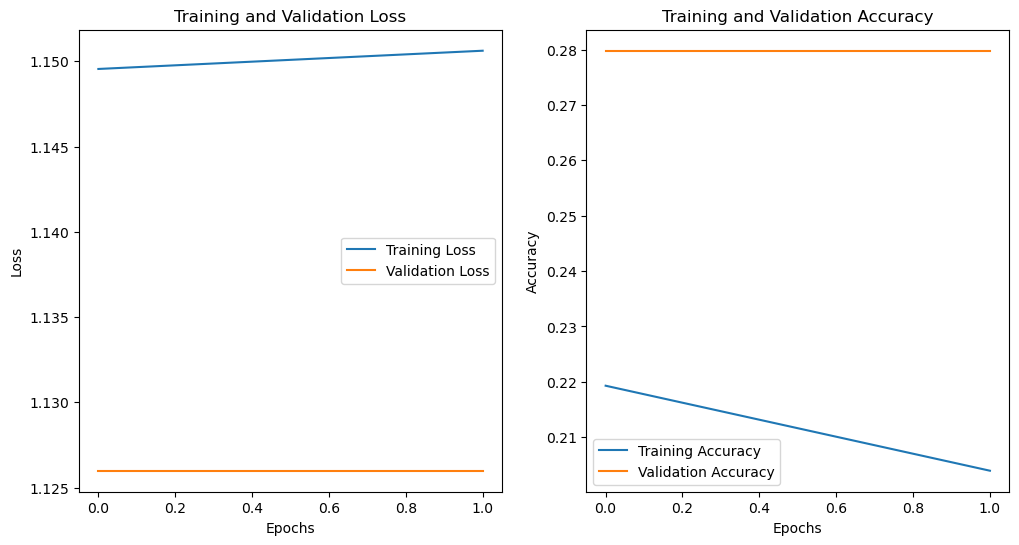

In [6]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:@|https?://)\S+", "", text)
    text = re.sub(r'[^x00-x7f]',r'', text)
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def filter_chars(text):
    return ' '.join(['' if ('$' in word) or ('&' in word) else word for word in text.split()])

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

def preprocess_texts(texts):
    texts = texts.fillna('')
    return [remove_mult_spaces(filter_chars(strip_all_entities(str(text)))) for text in texts]

df['text_clean'] = preprocess_texts(df['Subject'])
df_test['text_clean'] = preprocess_texts(df_test['Subject'])

print("Sample cleaned texts from training data:")
print(df['text_clean'].head())
print("Sample cleaned texts from testing data:")
print(df_test['text_clean'].head())

df['text_len'] = df['text_clean'].apply(lambda x: len(x.split()))
df_test['text_len'] = df_test['text_clean'].apply(lambda x: len(x.split()))

min_word_count = 1
df = df[df['text_len'] >= min_word_count]
df_test = df_test[df_test['text_len'] >= min_word_count]

if df.empty or df_test.empty:
    print("No texts left after filtering. Please check the filtering criteria.")
else:
    label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    df['label'] = df['Sentiment'].map(label_map)
    df_test['label'] = df_test['Sentiment'].map(label_map)

    df = df[df['label'].isin(label_map.values())]
    df_test = df_test[df_test['label'].isin(label_map.values())]

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def tokenize_texts(texts, tokenizer, max_length=128):
        print("Tokenizing the following texts:")
        print(texts.head())
        
        assert not texts.empty, "Text list is empty!"
        
        tokenized = tokenizer(
            texts.tolist(),
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )
        
        print("Tokenized output:")
        print(tokenized)
        
        return tokenized

    try:
        train_encodings = tokenize_texts(df['text_clean'], tokenizer)
        test_encodings = tokenize_texts(df_test['text_clean'], tokenizer)
        print("Tokenization successful!")
    except Exception as e:
        print(f"Error during tokenization: {e}")
        print(f"Training texts: {df['text_clean'].tolist()}")
        print(f"Testing texts: {df_test['text_clean'].tolist()}")
        train_encodings = None
        test_encodings = None

    if train_encodings is not None and test_encodings is not None:
        bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

        input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
        attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

        def call_bert(inputs):
            input_ids, attention_mask = inputs
            return bert_model(input_ids, attention_mask=attention_mask).logits

        bert_output = Lambda(call_bert, output_shape=(3,))([input_ids, attention_mask])

        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=bert_output)

        optimizer = Adam(learning_rate=5e-5)
        loss = SparseCategoricalCrossentropy(from_logits=True)
        metric = SparseCategoricalAccuracy('accuracy')

        model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

        train_dataset = tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': train_encodings['input_ids'],
                'attention_mask': train_encodings['attention_mask']
            },
            df['label'].values
        )).shuffle(len(df)).batch(16)

        test_dataset = tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': test_encodings['input_ids'],
                'attention_mask': test_encodings['attention_mask']
            },
            df_test['label'].values
        )).batch(16)

        num_batches_to_train = 100
        limited_train_dataset = train_dataset.take(num_batches_to_train)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(
            limited_train_dataset,
            validation_data=test_dataset,
            epochs=2,
            batch_size=16,
            callbacks=[early_stopping],
            verbose=2
        )

        num_batches_to_test = 20
        limited_test_dataset = test_dataset.take(num_batches_to_test)
        result_bert = model.predict(limited_test_dataset)
        y_pred_bert = result_bert.argmax(axis=1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

        y_test_limited = []
        for _, labels in limited_test_dataset:
            y_test_limited.extend(labels.numpy())
        y_test_limited = np.array(y_test_limited)

In [ ]:
import matplotlib.pyplot as plt

def plot_response_distribution(df, df_test):
    train_counts = df['label'].value_counts().sort_index()
    test_counts = df_test['label'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    train_counts.plot(kind='bar', color=['red', 'orange', 'green'])
    plt.title('Training Data Response Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)

    plt.subplot(1, 2, 2)
    test_counts.plot(kind='bar', color=['red', 'orange', 'green'])
    plt.title('Testing Data Response Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)

    plt.tight_layout()
    plt.show()

plot_response_distribution(df, df_test)

Training Data Score: 9
Testing Data Score: 7


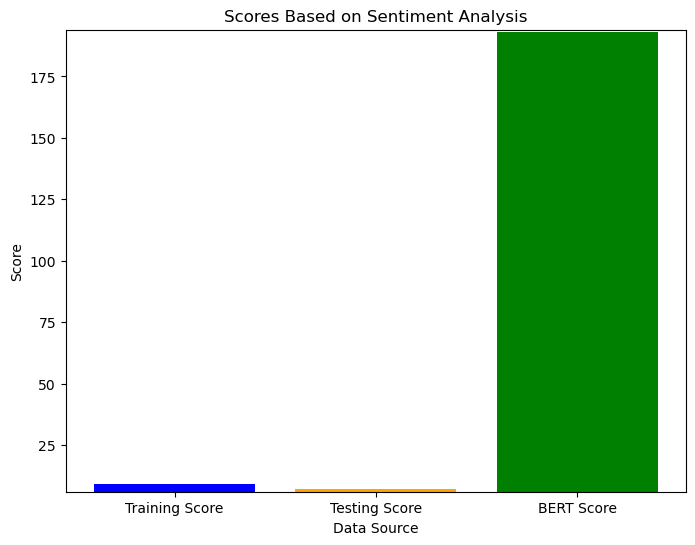

In [5]:
def calculate_scores(df, df_test):
    score_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    df['score'] = df['Sentiment'].map(score_map)
    df_test['score'] = df_test['Sentiment'].map(score_map)

    train_score = df['score'].sum()
    test_score = df_test['score'].sum()

    print(f"Training Data Score: {train_score}")
    print(f"Testing Data Score: {test_score}")

    return train_score, test_score

train_score, test_score = calculate_scores(df, df_test)

def plot_scores(train_score, test_score, bert_score):
    scores = [train_score, test_score, bert_score]
    labels = ['Training Score', 'Testing Score', 'BERT Score']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, scores, color=['blue', 'orange', 'green'])
    plt.title('Scores Based on Sentiment Analysis')
    plt.xlabel('Data Source')
    plt.ylabel('Score')
    plt.ylim(min(scores) - 1, max(scores) + 1)
    plt.show()

bert_score = np.sum(y_pred_bert)
plot_scores(train_score, test_score, bert_score)

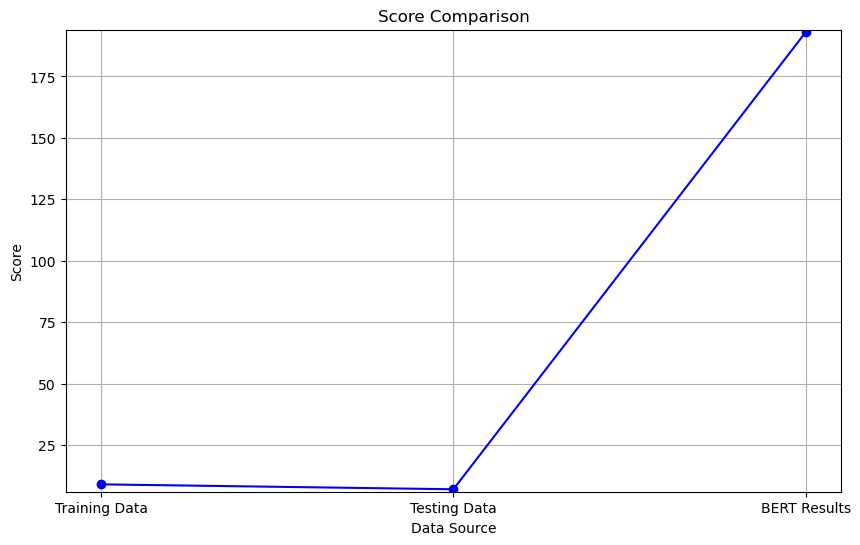

In [6]:
def plot_score_comparison(train_score, test_score, bert_score):
    scores = [train_score, test_score, bert_score]
    labels = ['Training Data', 'Testing Data', 'BERT Results']

    plt.figure(figsize=(10, 6))
    plt.plot(labels, scores, marker='o', linestyle='-', color='b')
    plt.title('Score Comparison')
    plt.xlabel('Data Source')
    plt.ylabel('Score')
    plt.grid(True)
    plt.ylim(min(scores) - 1, max(scores) + 1)
    plt.show()

plot_score_comparison(train_score, test_score, bert_score)

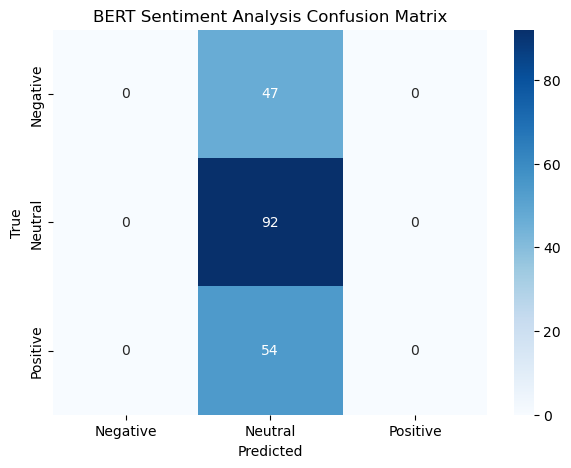

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        47
     Neutral       0.48      1.00      0.65        92
    Positive       0.00      0.00      0.00        54

    accuracy                           0.48       193
   macro avg       0.16      0.33      0.22       193
weighted avg       0.23      0.48      0.31       193



/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [7]:
cm = confusion_matrix(y_test_limited, y_pred_bert)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Sentiment Analysis Confusion Matrix')
plt.show()

print('Classification Report for BERT:\n', classification_report(y_test_limited, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_limited == i, result_bert[:, i])
    roc_auc = roc_auc_score(y_test_limited == i, result_bert[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(result_bert.flatten(), kde=True, bins=30)
plt.title('Predicted Probabilities Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
colors = ['red', 'orange', 'green']
for i, color in zip(range(3), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {i} (area = {average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()